#Disaster Tweets Analysis using Natural Language Processing

In [ ]:
#Mount google colab and drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 4.0 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium import plugins

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
import text_hammer as th

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from keras.callbacks import ReduceLROnPlateau
from keras.losses import BinaryCrossentropy

import transformers
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments
from transformers import TFBertModel, Trainer
from tokenizers import Tokenizer
from transformers import BertTokenizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Loading the dataset
train_path="/content/drive/MyDrive/Twitter Disaster/train.csv"
test_path="/content/drive/MyDrive/Twitter Disaster/test.csv"
ss_path="/content/drive/MyDrive/Twitter Disaster/sample_submission.csv"
train=pd.read_csv(train_path)
test=pd.read_csv(test_path)
sample_submission=pd.read_csv(ss_path)

In [ ]:
train['target'].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: target, dtype: int64

In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [ ]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
#Summarizing the train data
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
print("The shape of the training data is --> ",train.shape)
print("The shape of the test data is --> ",test.shape)

The shape of the training data is -->  (7613, 5)
The shape of the test data is -->  (3263, 4)


##Problem Statement
Given a tweet we have find whether it is a tweet about a real disaster or not
#MetaData
id - a unique identifier for each tweet

text - the text of the tweet

location - the location the tweet was sent from (may be blank)

keyword - a particular keyword from the tweet (may be blank)

target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

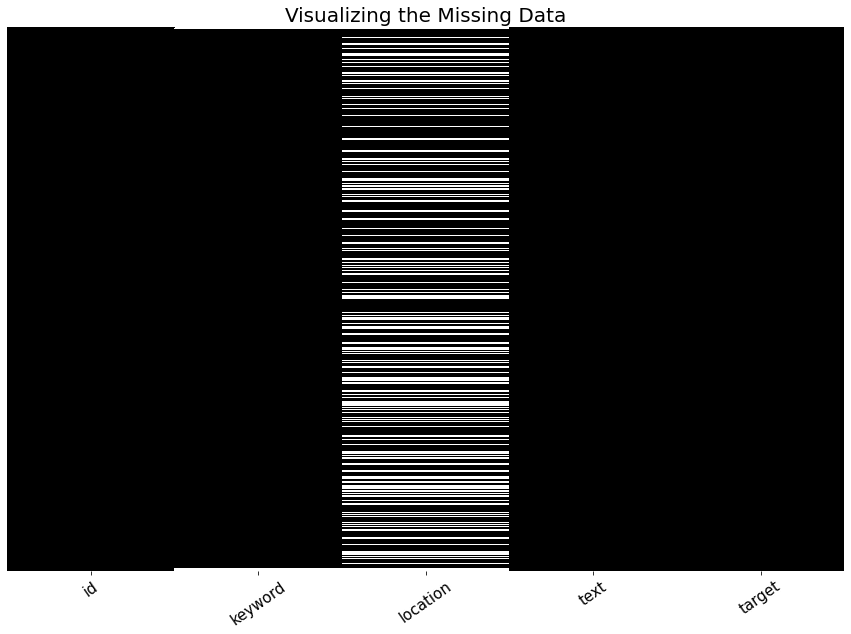

In [ ]:
plt.figure(figsize = (15, 10))
sns.heatmap(train.isna(), yticklabels = False, cbar = False, cmap = 'afmhot')
plt.title("Visualizing the Missing Data", fontsize = 20)
plt.xticks(rotation = 35, fontsize = 15)
plt.show()


In [ ]:
train['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

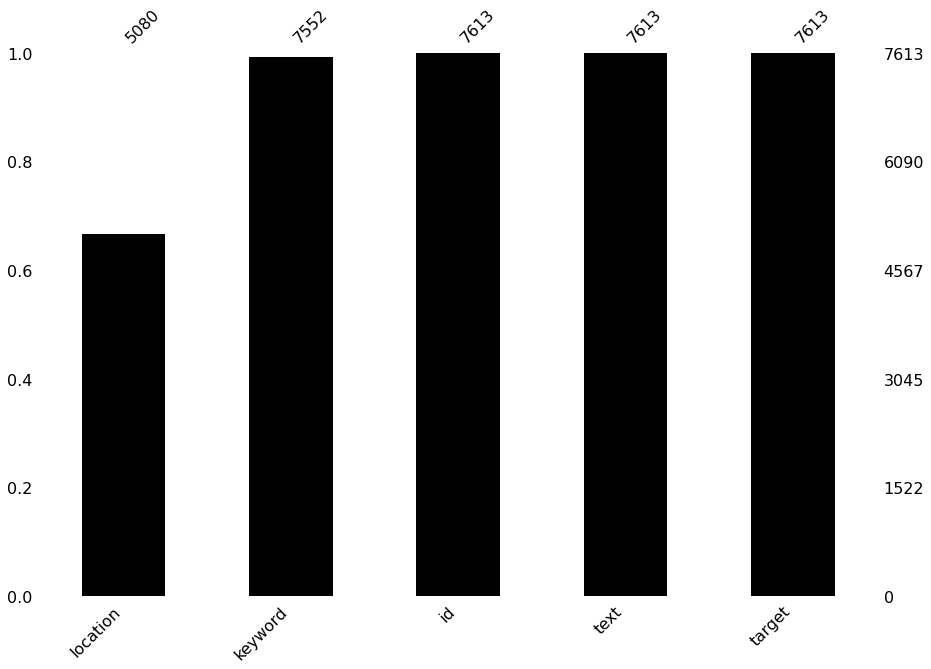

In [ ]:
msno.bar(train, color = (0, 0, 0), sort = "ascending", figsize = (15, 10))
plt.show()

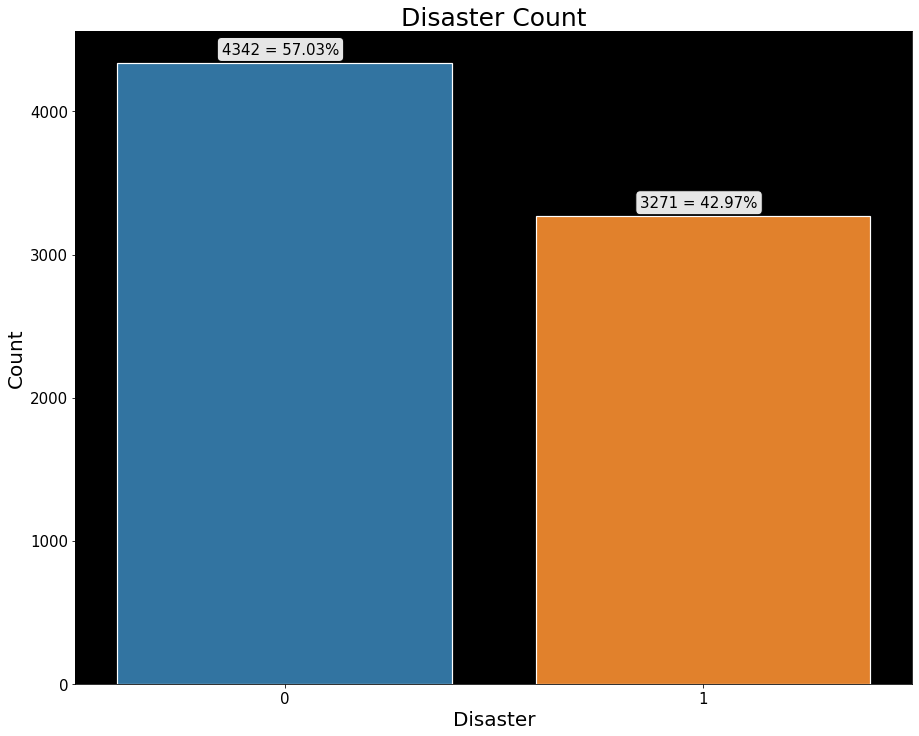

In [ ]:
plt.figure(figsize = (15, 12))
ax = plt.axes()
ax.set_facecolor('black')
ax = sns.countplot(x = 'target', data = train, edgecolor = 'white', linewidth = 1.2)
plt.title('Disaster Count', fontsize = 25)
plt.xlabel('Disaster', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
ax.xaxis.set_tick_params(labelsize = 15)
ax.yaxis.set_tick_params(labelsize = 15)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
        ax.annotate('{:.0f} = {:.2f}%'.format(p.get_height(), (p.get_height() / len(train['target'])) * 100), (p.get_x() + 0.25, p.get_height() + 60),
                   color = 'black',
                   bbox = bbox_args,
                   fontsize = 15)
plt.show()

In [ ]:
train['location'].value_counts()[:10]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

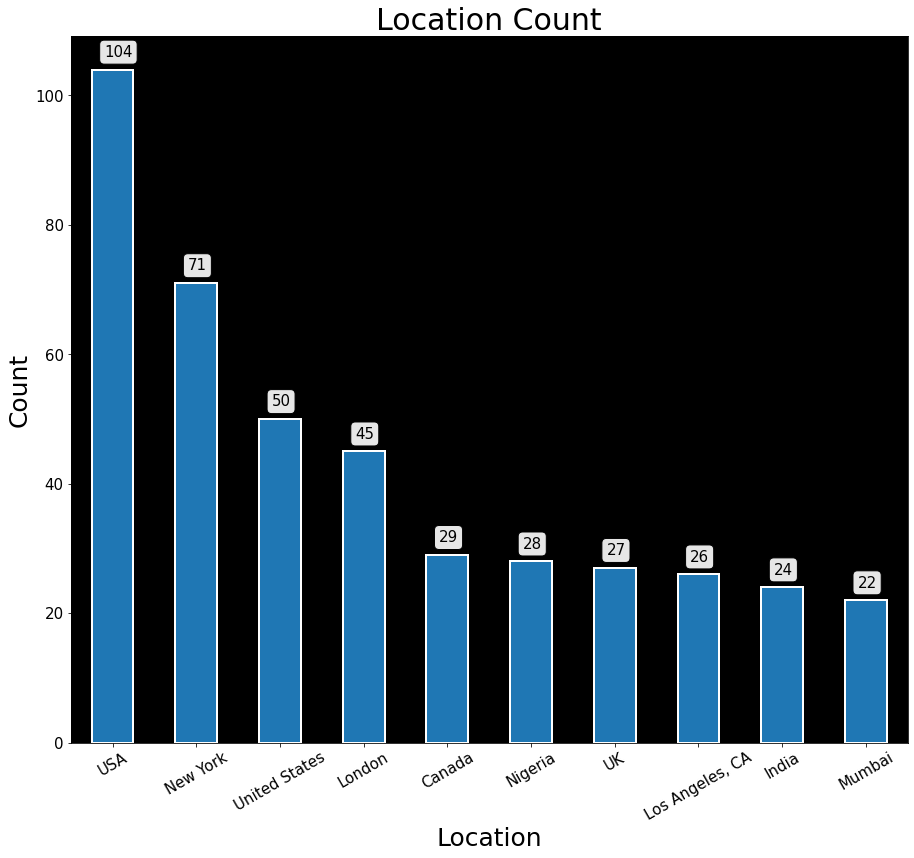

In [ ]:
plt.figure(figsize = (15, 13))
ax = plt.axes()
ax.set_facecolor('black')
ax = ((train.location.value_counts())[:10]).plot(kind = 'bar', linewidth = 2, edgecolor = 'white')
plt.title('Location Count', fontsize = 30)
plt.xlabel('Location', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
ax.xaxis.set_tick_params(labelsize = 15, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 15)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.15, p.get_height() + 2),
                   bbox = bbox_args,
                   fontsize = 15)

In [ ]:
new_df = pd.DataFrame()
new_df['location'] = ((train['location'].value_counts())[:10]).index
new_df['count'] = ((train['location'].value_counts())[:10]).values
geolocator = Nominatim(user_agent = 'Rahil')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 0.5)
lat = {}
long = {}
for i in new_df['location']:
    location = geocode(i)
    lat[i] = location.latitude
    long[i] = location.longitude
new_df['latitude'] = new_df['location'].map(lat)
new_df['longitude'] = new_df['location'].map(long)
map = folium.Map(location = [10.0, 10.0], tiles = 'CartoDB dark_matter', zoom_start = 1.5)
markers = []
title = '''<h1 align = "center" style = "font-size: 35px"><b>Top 10 Tweet Locations</b></h1>'''
for i, r in new_df.iterrows():
    loss = r['count']
    if r['count'] > 0:
        counts = r['count'] * 0.4
        folium.CircleMarker([float(r['latitude']), float(r['longitude'])], radius = float(counts), fill = True).add_to(map)
map.get_root().html.add_child(folium.Element(title))
map

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
non_list_stopwords = stopwords.words('english')
stopwords = list(stopwords.words('english'))
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
non_disaster_tweets_length = (train[train['target'] == 0])['text'].str.len()
disaster_tweets_length = (train[train['target'] == 1])['text'].str.len()
print(non_disaster_tweets_length)
print(disaster_tweets_length)

15       14
16       13
17       16
18       17
19       28
       ... 
7581    104
7582     80
7584    127
7587     18
7593     60
Name: text, Length: 4342, dtype: int64
0        69
1        38
2       133
3        65
4        88
       ... 
7608     83
7609    125
7610     65
7611    137
7612     94
Name: text, Length: 3271, dtype: int64


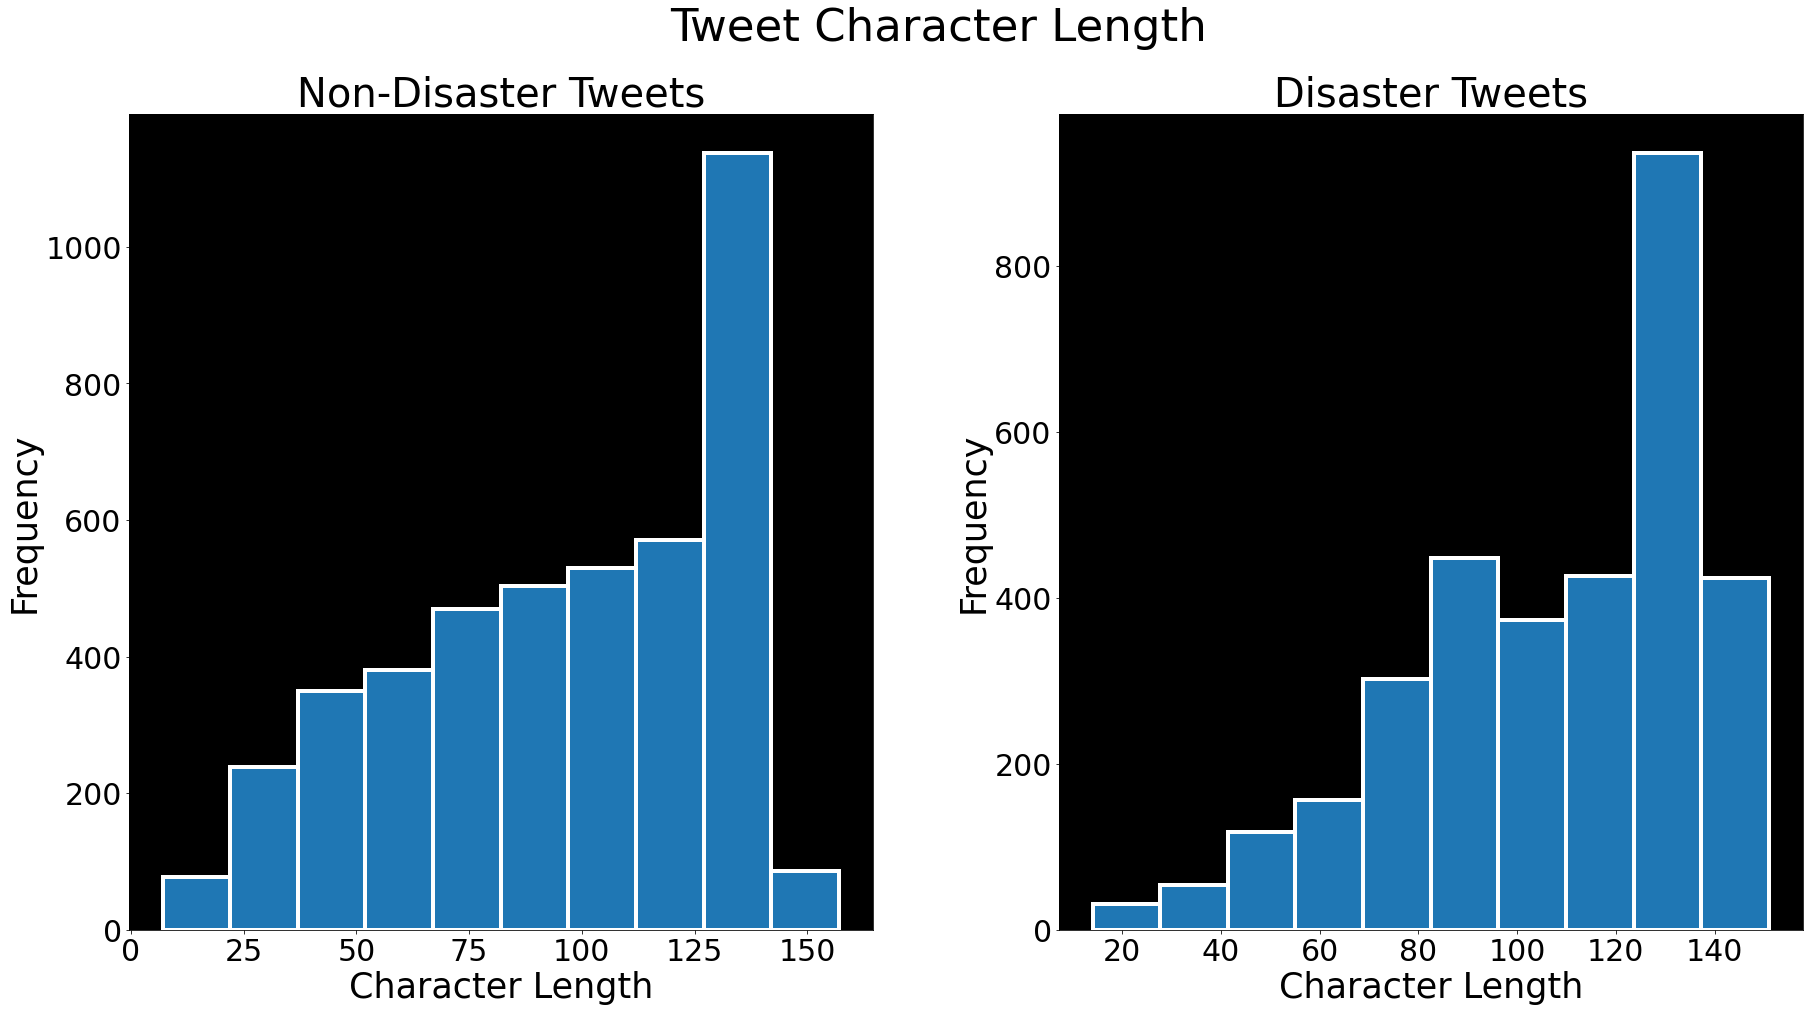

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (30, 15))
fig.suptitle('Tweet Character Length', fontsize = 45)

axes[0].set_facecolor('black')
axes[0].hist(non_disaster_tweets_length, edgecolor = 'white', linewidth = 4)
axes[0].set_title('Non-Disaster Tweets', fontsize = 40)
axes[0].set_xlabel('Character Length', fontsize = 35)
axes[0].set_ylabel('Frequency', fontsize = 35)
axes[0].xaxis.set_tick_params(labelsize = 30)
axes[0].yaxis.set_tick_params(labelsize = 30)

axes[1].set_facecolor('black')
axes[1].hist(disaster_tweets_length, edgecolor = 'white', linewidth = 4)
axes[1].set_title('Disaster Tweets', fontsize = 40)
axes[1].set_xlabel('Character Length', fontsize = 35)
axes[1].set_ylabel('Frequency', fontsize = 35)
axes[1].xaxis.set_tick_params(labelsize = 30)
axes[1].yaxis.set_tick_params(labelsize = 30)

plt.subplots_adjust(wspace = 0.25, hspace = 0.1)
plt.show()

In [ ]:
class tweet_functions:

    '''Getting the count of different attributes of our tweets'''

    def __init__(self, column):
        self.column = column

    def count_characters(self):
        return((self.column).apply(lambda word: len(str(word))))

    def count_words(self):
        return((self.column).apply(lambda word: len(str(word).split())))

    def count_urls(self):
        return((self.column).apply(lambda word: len([url for url in str(word).lower().split() if 'http' in word or 'https' in word])))

    def count_hashtags(self):
        return((self.column).apply(lambda word: len([hashtag for hashtag in str(word) if '#' in hashtag])))

    def count_tags(self):
        return((self.column).apply(lambda word: len([tag for tag in str(word) if '@' in tag])))

    def count_stopwords(self):
        return((self.column).apply(lambda word: len([word for word in str(word).lower().split() if word in stopwords])))

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"U0001F600-U0001F64F"  # emoticons
                           u"U0001F300-U0001F5FF"  # symbols & pictographs
                           u"U0001F680-U0001F6FF"  # transport & map symbols
                           u"U0001F1E0-U0001F1FF"  # flags (iOS)
                           u"U00002702-U000027B0"
                           u"U000024C2-U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
for i in train['text']:
  ans = re.sub(r'(!)1+', '', i)

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 21.1 MB/s eta 0:00:00


In [ ]:
import contractions
for t in train['text']:
  contractions.fix(t)

In [ ]:
train['text'] = train['text'].str.lower() # convert to lowercase
train['text'] = train['text'].str.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
train['text'] = train['text'].apply(lambda text: ' '.join([word for word in str(text).split() if word not in stopwords])) # remove stopwords
train['text'] = train['text'].apply(lambda text: remove_emoji(text)) # remove emojis
train['text'] = train['text'].apply(lambda text: th.cont_exp(text)) # convert i'm to i am, you're to you are, etc
print(train['text'])

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3        people receive wildfires evacuation orders ca...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610             m  utckm volcano hawaii httptcozdtoydebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object


In [ ]:
for i in test['text']:
  ans = re.sub(r'(!)1+', '', i)
for t in test['text']:
  contractions.fix(t)

In [ ]:
test['text'] = test['text'].str.lower() # convert to lowercase
test['text'] = test['text'].str.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
test['text'] = test['text'].apply(lambda text: ' '.join([word for word in str(text).split() if word not in stopwords])) # remove stopwords
test['text'] = test['text'].apply(lambda text: remove_emoji(text)) # remove emojis
test['text'] = test['text'].apply(lambda text: th.cont_exp(text)) # convert i'm to i am, you're to you are, etc
print(test['text'])

0                             happened terrible car crash
1       heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                    typhoon soudelor kills  china taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety faste...
3259    storm ri worse last hurricane cityampothers ha...
3260      green line derailment chicago httptcoutbxlcbiuy
3261    meg issues hazardous weather outlook hwo httpt...
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object


In [ ]:
counter = Counter()
for text in train['text'].values:
    for word in text.split():
        counter[word] += 1
counter.most_common(10)

[('like', 345),
 ('amp', 300),
 ('im', 299),
 ('fire', 250),
 ('new', 236),
 ('get', 230),
 ('via', 220),
 ('people', 214),
 ('news', 197),
 ('one', 193)]

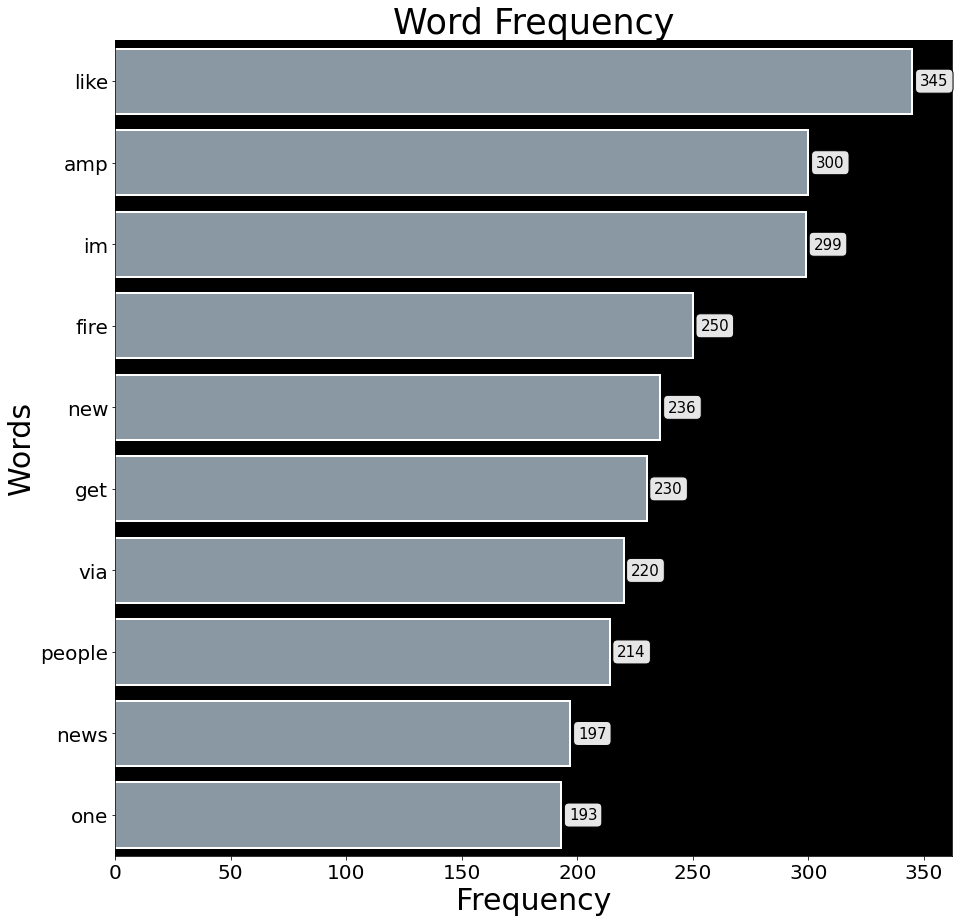

In [ ]:
data = dict(sorted(counter.items(), key = lambda x: x[1] ,reverse = True)[:10])
words = list(data.keys())
frequency = list(data.values())

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 15))
ax.set_facecolor('black')
ax = sns.barplot(x = frequency, y = words, color = '#8699A7', edgecolor = 'white', linewidth = 2)
plt.title('Word Frequency', fontsize = 35)
plt.xlabel('Frequency', fontsize = 30)
plt.ylabel('Words', fontsize = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
    width = p.get_width()
    plt.text(9.5 + p.get_width(), p.get_y() + 0.5 * p.get_height(), '{:1.0f}'.format(width),
             ha = 'center',
             va = 'center',
             color = 'black',
             bbox = bbox_args,
             fontsize = 15)
plt.show()

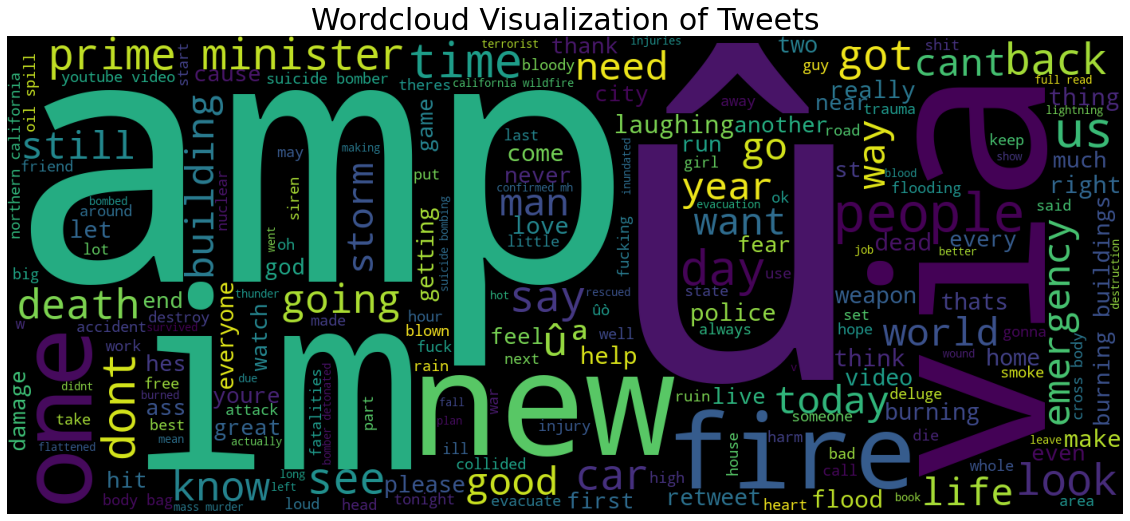

In [ ]:
wordcloud = WordCloud(width = 1400, height = 600, background_color = 'black').generate(''.join(text for text in train['text']))
plt.figure(figsize = (20, 10))
plt.title('Wordcloud Visualization of Tweets', fontsize = 30)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
5,8,NaN,NaN,rockyfire update california hwy closed direct...,1
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1
7,13,NaN,NaN,im top hill see fire woods,1
8,14,NaN,NaN,theres emergency evacuation happening building...,1
9,15,NaN,NaN,im afraid tornado coming area,1


#As the id column does not add any importance so we remove them. We can also remove the keyword and location column as it has missing values. In the future we can handle the missing value and add these two features for further analysis

In [ ]:
train = train.drop(columns = ['id', 'keyword', 'location'])

In [ ]:
train.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders ca...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X_train = tokenizer(
    text = train['text'].tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

X_test = tokenizer(
    text = test['text'].tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
print(X_train)
print(X_test)

{'input_ids': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[  101, 15616,  3114, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  3901,  2356, ...,     0,     0,     0],
       ...,
       [  101,  1049, 11396, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  6745,  5014, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
{'input_ids': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[  101,  3047,  6659, ...,     0,     0,     0],
       [  101,  2657,  8372, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       ...,
       [  101,  2665,  2240, ...,     0,

In [ ]:
X_train['input_ids'].shape

TensorShape([7613, 36])

In [ ]:
X_train['attention_mask'].shape

TensorShape([7613, 36])

In [ ]:
y_train = train['target'].values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
input_ids = Input(shape=(36,), dtype=tf.int32, name = 'input_ids')
input_mask = Input(shape=(36,), dtype=tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1]
layer = layers.Dropout(0.2)(embeddings)
layer = layers.Dense(32, activation = 'relu')(layer)
y = layers.Dense(1, activation = 'sigmoid')(layer)

model = keras.Model(inputs = [input_ids, input_mask], outputs = y)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                            

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 6e-6, epsilon = 1e-8, decay = 0.01, clipnorm = 1.0),
    loss = BinaryCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
classifier = model.fit(
    x = {'input_ids': X_train['input_ids'],
        'attention_mask': X_train['attention_mask']
        },
    y = y_train,
    validation_split = 0.05,
    epochs = 5,
    batch_size = 16
)

Epoch 1/5


In [ ]:
model.evaluate({'input_ids': X_train['input_ids'],
                'attention_mask': X_train['attention_mask']},
                 y_train)

In [ ]:
test_df = test[['id', 'text']]
pred = model.predict({'input_ids': X_test['input_ids'],
                      'attention_mask': X_test['attention_mask']})
print(pred)
pred = tf.squeeze(tf.round((pred)))
print(np.array(pred))